# Loading and working with processed paedal Visium data - post cell2location deconvolution

In [1]:
import numpy as np
import scipy as sp
import scanpy as sc
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import re
import os
import scipy.stats
from numpy import asarray as ar
from collections import Counter
import anndata as ad
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to show output from all the lines in a cells
pd.set_option('display.max_column',None) # display all the columns in pandas
pd.options.display.max_rows = 100

from datetime import date
today = str(date.today())
sc.settings.verbosity = 1
sc.logging.print_version_and_date()
%load_ext autoreload
%autoreload 2

Running Scanpy 1.9.1, on 2023-09-20 22:35.


In [2]:
## For correct plotting of the images
import matplotlib
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
sc.settings.set_figure_params(dpi = 150, color_map = 'RdPu', dpi_save = 150, vector_friendly = True, format = 'pdf')

In [3]:
# output folder 
import os
os.chdir('')
os.getcwd()

'/nfs/team205/ny1/ThymusSpatialAtlas/new_Figure3'

# Explore gene expression and cytokine profiles  

AnnData object with n_obs × n_vars = 22533 × 28164
    obs: 'Sample', 'Sample_hr', 'SampleID', 'SlideID', 'Position', 'in_tissue', 'array_row', 'array_col', 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'percent_mito', 'annotations_level_0', 'annotations_level_0_number', 'annotations_level_1', 'annotations_level_1_number', 'annotations_lobules_0', 'annotations_lobules_0_number', 'L2_dist_annotations_level_0_Artifacts', 'L2_dist_annotations_level_0_Cortex', 'L2_dist_annotations_level_0_Edge', 'L2_dist_annotations_level_0_Medulla', 'L2_dist_annotations_level_1_HS', 'L2_dist_annotations_level_1_PVS', 'L2_dist_annotations_level_1_fat', 'L2_dist_annotations_level_1_vessels', 'L2_dist_annotations_level_0_lymph', 'L2_dist_annotations_level_1_unassigned', 'cm', 'cc', 'cma_v2', 'manual_bin_cma_v2', 'manual_bin_cma_v2_int', 'Image_name', 'Image_jpg', 'section_thickness (um)', 'permebialisation(min)', 'RIN/DV200', 'Visium_type', 'Funding', 'Sequen

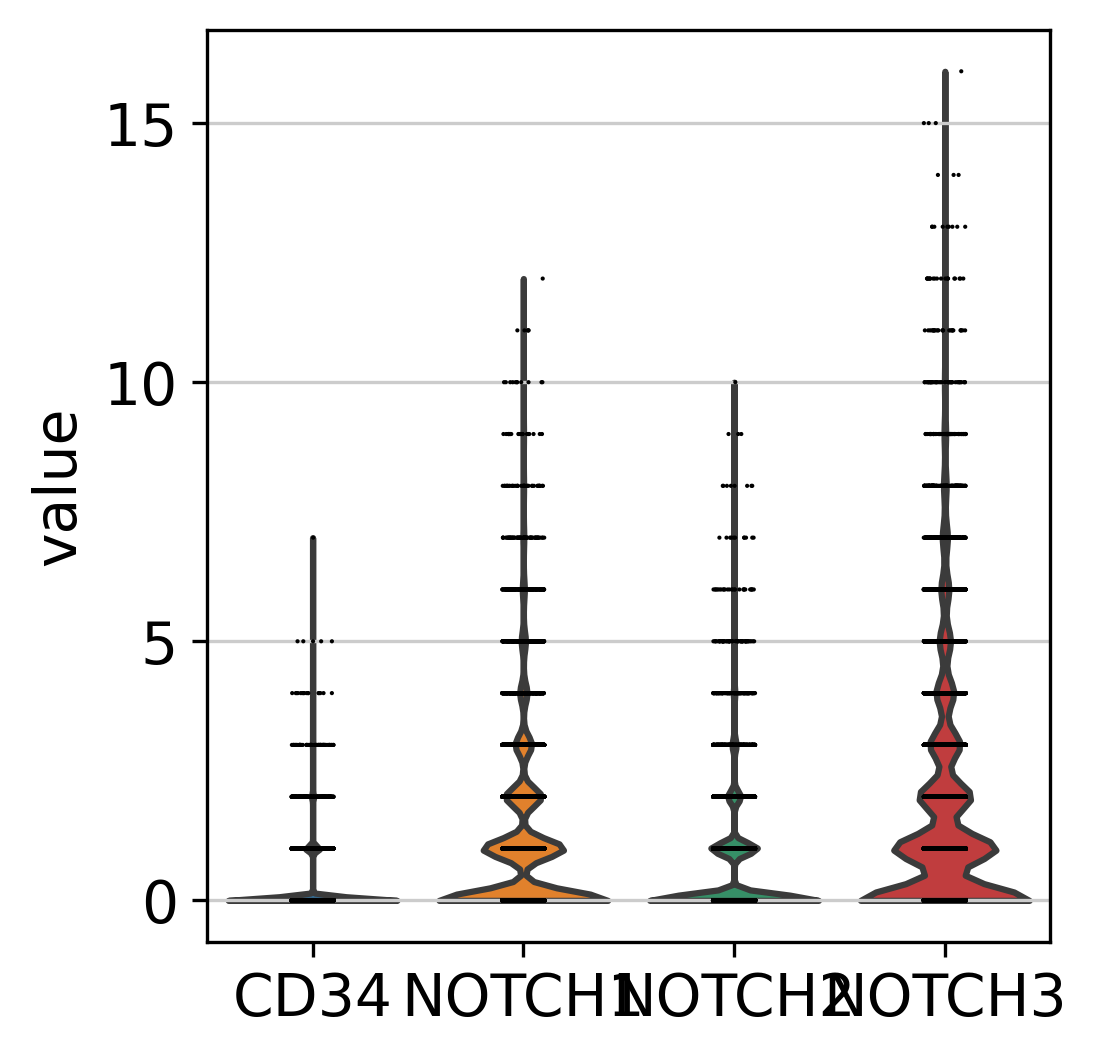

In [4]:
adata_paed_cma =  sc.read_h5ad('')
adata_paed_cma
# make sure it's count data 
list = ['CD34','NOTCH1','NOTCH2','NOTCH3',]
sc.pl.violin(adata_paed_cma, keys =list,layer='counts')

In [5]:
# remove artifacts structures 
import warnings
warnings.filterwarnings('ignore')
adata_paed_cma = adata_paed_cma[adata_paed_cma.obs['annotations_level_1']!="fat"].copy()
adata_paed_cma = adata_paed_cma[adata_paed_cma.obs['annotations_level_1']!="vessels"].copy()

# correlations with axis 

In [6]:
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/software/ImageSpot/')
import imagespot as ims

Capsular= (-0.75>cma_v2)
Sub-Capsular= (-0.75<=cma_v2) & (-0.62>cma_v2)
Cortical level I= (-0.62<=cma_v2) & (-0.55>cma_v2)
Cortical level II= (-0.55<=cma_v2) & (-0.45>cma_v2)
Cortical level III= (-0.45<=cma_v2) & (-0.3>cma_v2)
Cortical CMJ= (-0.3<=cma_v2) & (0.1>cma_v2)
Medullar CMJ= (0.1<=cma_v2) & (0.55>cma_v2)
Medullar level I= (0.55<=cma_v2) & (0.65>cma_v2)
Medullar level II= (0.65<=cma_v2) & (0.7>cma_v2)
Medullar level III= (0.7=<cma_v2)


Cortical level II     4111
Cortical level I      3653
Cortical level III    2565
Capsular              2149
Medullar level III    2034
Cortical CMJ          1912
Medullar CMJ          1872
Sub-Capsular          1520
Medullar level I      1487
Medullar level II     1211
Name: manual_bin_cma_v2, dtype: int64

<AxesSubplot:>

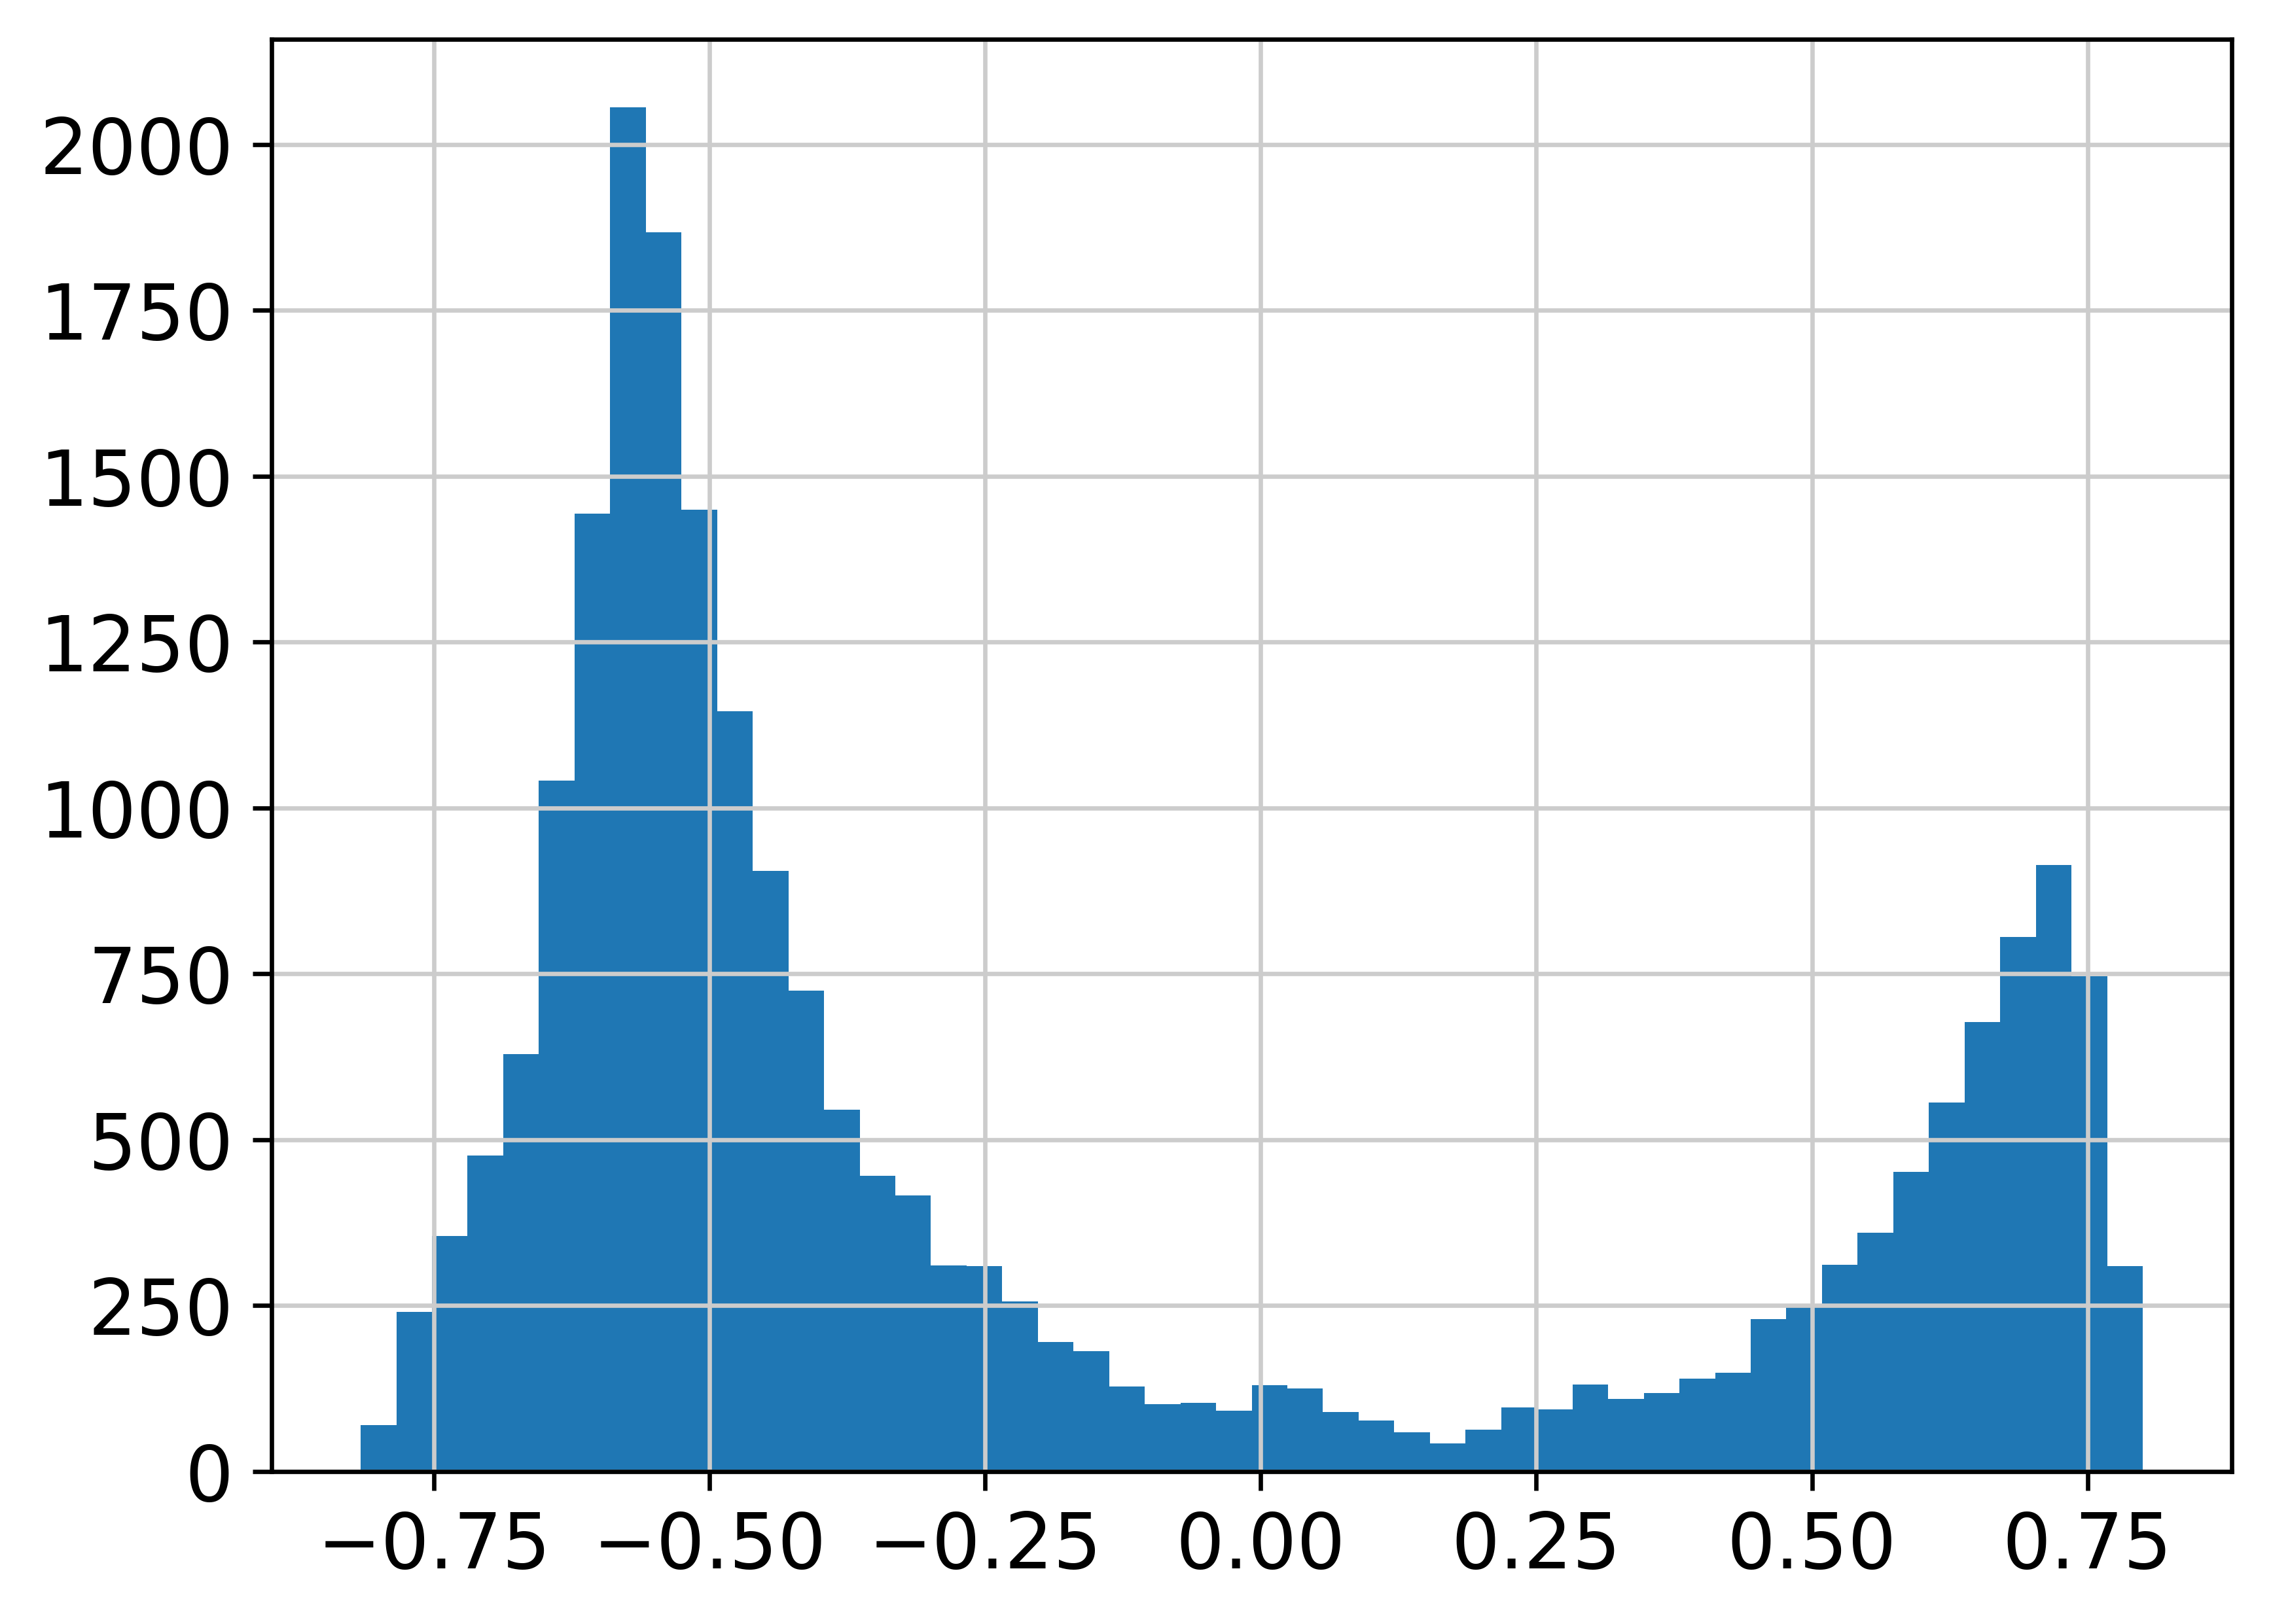

In [7]:
import seaborn as sns
ct_order = ['Capsular','Sub-Capsular','Cortical level I','Cortical level II','Cortical level III','Cortical CMJ','Medullar CMJ','Medullar level I','Medullar level II','Medullar level III']
ct_color_map = dict(zip(ct_order, np.array(sns.color_palette("tab20", len(ct_order)))[range(len(ct_order))]))
ct2_values = [-0.75,-0.62,-0.55,-0.45,-0.3,0.1,0.55,0.65,0.7]
adata_paed_cma.obs = ims.bin_axis(ct_order ,ct2_values,adata_paed_cma.obs,'cma_v2')   
adata_paed_cma.obs.loc[adata_paed_cma.obs['annotations_level_0']=='Edge','manual_bin_cma_v2'] = 'Capsular'
adata_paed_cma.obs['manual_bin_cma_v2'] = adata_paed_cma.obs['manual_bin_cma_v2'].cat.reorder_categories(ct_order)
adata_paed_cma.obs['manual_bin_cma_v2'].value_counts()
adata_paed_cma.obs['cma_v2'].hist(bins=50)
plt.show()

In [12]:
cytokines = pd.read_csv(,header=None)


['CXCL3', 'CCL25', 'BMP8A', 'CXCL12', 'CXCL8', 'GDF11', 'BMP7', 'CCL14', 'IL33', 'CCL2', 'CCL28', 'CCL18', 'TNFSF11', 'CCL13', 'TNFSF9', 'TNFSF10', 'IL4R', 'CCL17', 'CXCL9', 'CXCL13', 'CXCL11', 'CXCL10', 'CCL22', 'LTA', 'IL1RN', 'CD70', 'TNF', 'CCL3', 'IL1B', 'CCL1', 'CCL20', 'CXCL1', 'CXCL6', 'SPP1', 'IL1R1', 'IL34', 'IL15RA', 'CSF1', 'CXCL14', 'IL1R2', 'CCL21', 'IL23A', 'FLT3LG', 'CCL5', 'CD40LG', 'CXCL16', 'XCL1', 'CCL19', 'TNFSF13', 'CX3CL1', 'IL18', 'TGFB3', 'IL1RAP', 'TNFSF13B', 'TNFSF14', 'CCL4', 'XCL2', 'IL15', 'EBI3', 'IL6R', 'IL6ST', 'IL12B', 'TNFSF12']


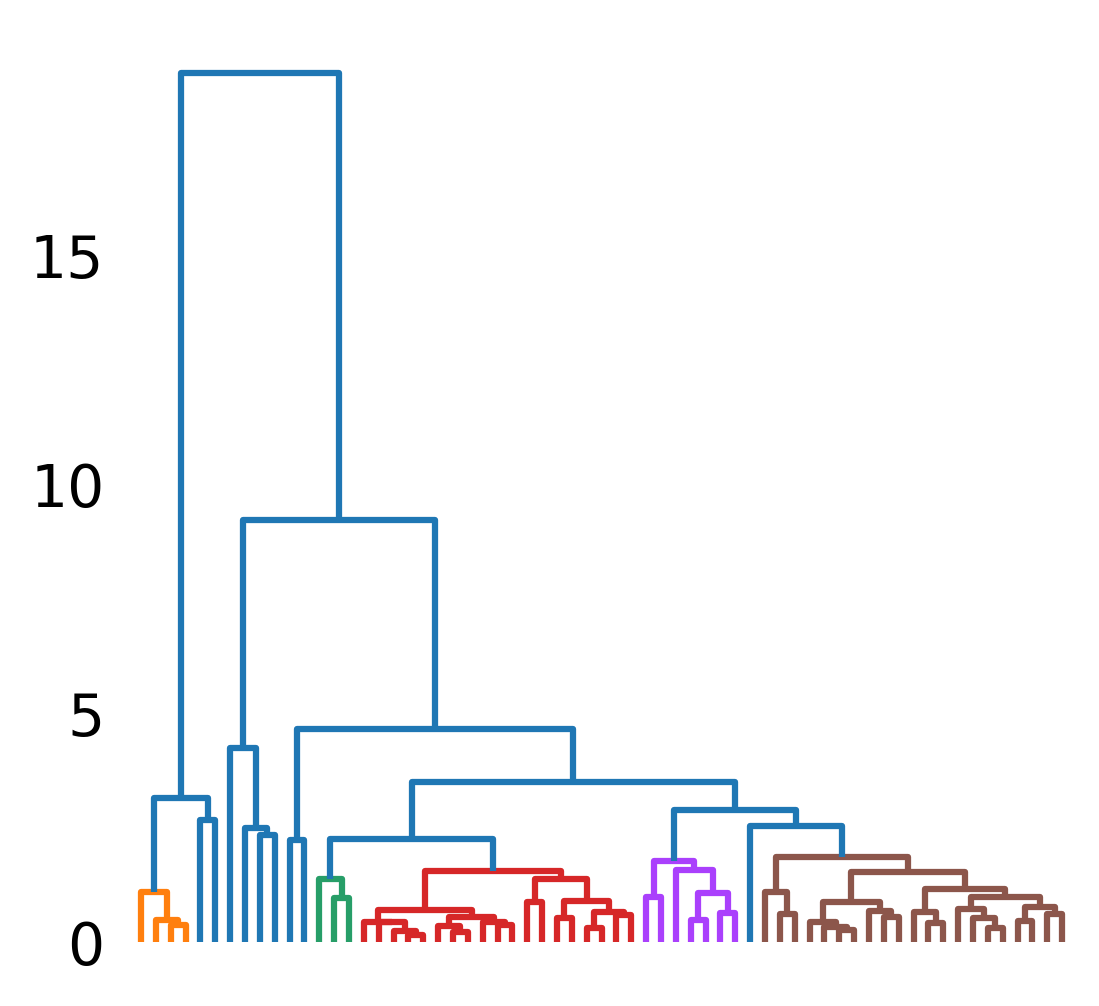

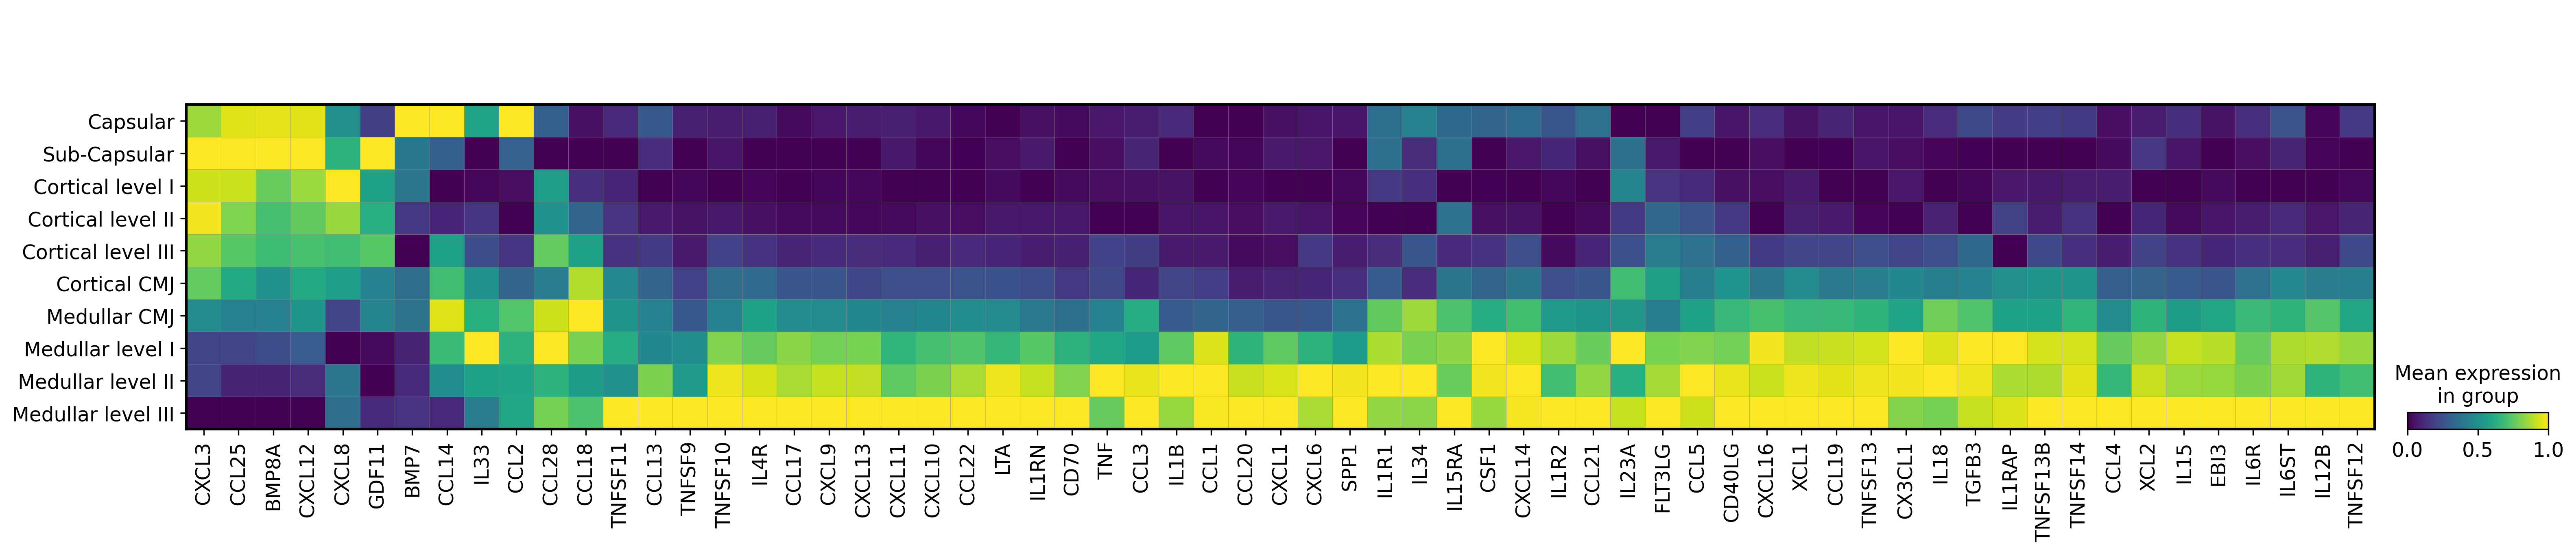

In [14]:
# cluster cytokies by expression profiles across bins
from sklearn.preprocessing import scale
from scipy.cluster.hierarchy import linkage, dendrogram

## For correct plotting of the images
import matplotlib
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
sc.settings.set_figure_params(dpi = 150, color_map = 'RdPu', dpi_save = 150, vector_friendly = True, format = 'pdf')
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/new_Figure3/')


# Subset dataframe, calculate mean expression and standardize
adata_selected = adata_paed_cma[:, adata_paed_cma.var_names.isin(cytokines[0])]
mean_expression_df = pd.DataFrame(adata_selected.X.toarray(), 
                                  columns=adata_selected.var_names, 
                                  index=adata_selected.obs_names).groupby(adata_paed_cma.obs['manual_bin_cma_v2']).mean()
mean_expression_std = pd.DataFrame(scale(mean_expression_df, axis=0),
                                   index=mean_expression_df.index,
                                   columns=mean_expression_df.columns)

# Create dendrogram
transposed_df = mean_expression_std.transpose()
Z = linkage(transposed_df, method='ward')
dn = dendrogram(Z, orientation='top', labels=transposed_df.index, leaf_font_size=5,p=10,color_threshold=2)

# Set plotting preferences
plt.grid(False)
plt.rcParams['figure.facecolor'] = 'white'
for spine in plt.gca().spines.values(): spine.set_visible(False)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=True, labelbottom=False)

# Get and print gene order
gene_order = [transposed_df.index[i] for i in dn['leaves']]
print(gene_order)

# Save the dendrogram figure as a PDF
plt.savefig('')

plt.show()

# Create matrix plot using scanpy
sc.pl.matrixplot(adata_paed_cma,var_names=gene_order,groupby='manual_bin_cma_v2',cmap='viridis',standard_scale='var',dendrogram=False,save='matrixplot_paed.pdf')


np.save('', gene_order)


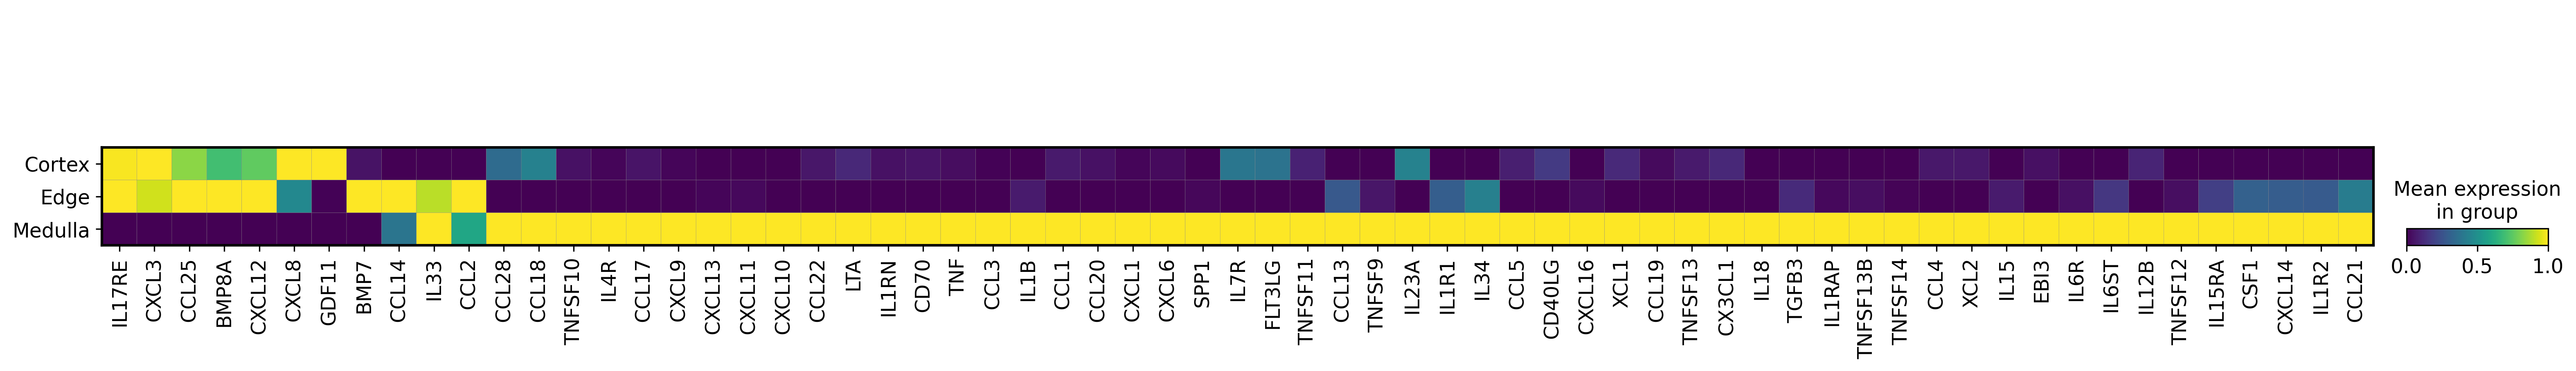

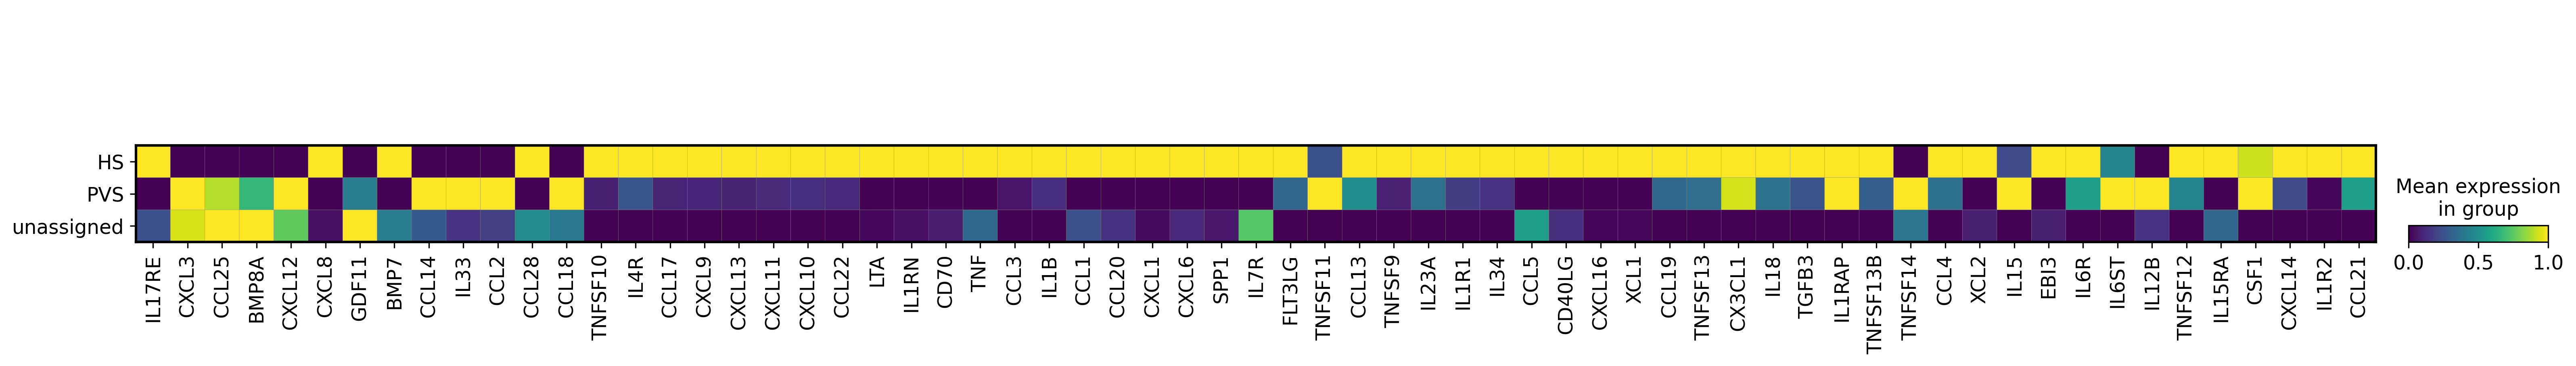

In [13]:
sc.pl.matrixplot(adata_paed_cma,var_names=gene_order,groupby='annotations_level_0',cmap='viridis',standard_scale='var',dendrogram=False)
sc.pl.matrixplot(adata_paed_cma,var_names=gene_order,groupby='annotations_level_1',cmap='viridis',standard_scale='var',dendrogram=False)

# CMA marker genes

# Analyse cell level

In [8]:
celltypes = adata_paed_cma.uns['mod']['factor_names']
cellab_paed = sc.AnnData(adata_paed_cma.obs[celltypes], 
                         obs = adata_paed_cma.obs.drop(celltypes, axis = 1),obsm = adata_paed_cma.obsm)

cellab_paed.var_names
sc.pp.normalize_total(cellab_paed,target_sum=100)
os.chdir('')


Index(['B-memory', 'B-naive', 'B-plasma', 'DC1', 'DC2', 'EC-Art', 'EC-Art-ELN',
       'EC-Cap', 'EC-Lymphatic', 'EC-Ven', 'InterloFb', 'Macrophage-APOC2',
       'Macrophage-SPIC1', 'Monocyte_IL1B', 'Myelocyte', 'Neutrophil',
       'Pericyte', 'Pericyte_CCL19', 'Pericyte_COL1A1', 'PeriloFb', 'SMC',
       'TEC-cilliated', 'TEC-myo', 'TEC-neuro', 'T_CD4', 'T_CD8',
       'T_CD8_memory', 'T_CD8αα(I)', 'T_CD8αα(II)', 'T_CD8αα(entry)',
       'T_DN(P)', 'T_DN(Q)', 'T_DN(early)', 'T_DP(P)', 'T_DP(Q)',
       'T_DP(Q)-CD99', 'T_DP(Q)-early', 'T_DP(Q)-late_vdj', 'T_ETP', 'T_NK',
       'T_Treg(agonist)', 'T_Treg-diff_1', 'T_Treg-diff_2', 'T_Treg_CD8',
       'T_Treg_mature', 'T_Treg_recirc', 'T_αβT(entry)', 'T_γδT', 'aDC1',
       'aDC2', 'aDC3', 'cTECI', 'cTECII', 'cTECIII', 'mTECI', 'mTECI-trans',
       'mTECII', 'mTECIII', 'mcTEC', 'medFB-MHCIIh', 'medFb', 'medFb-RGS5',
       'pDC'],
      dtype='object')

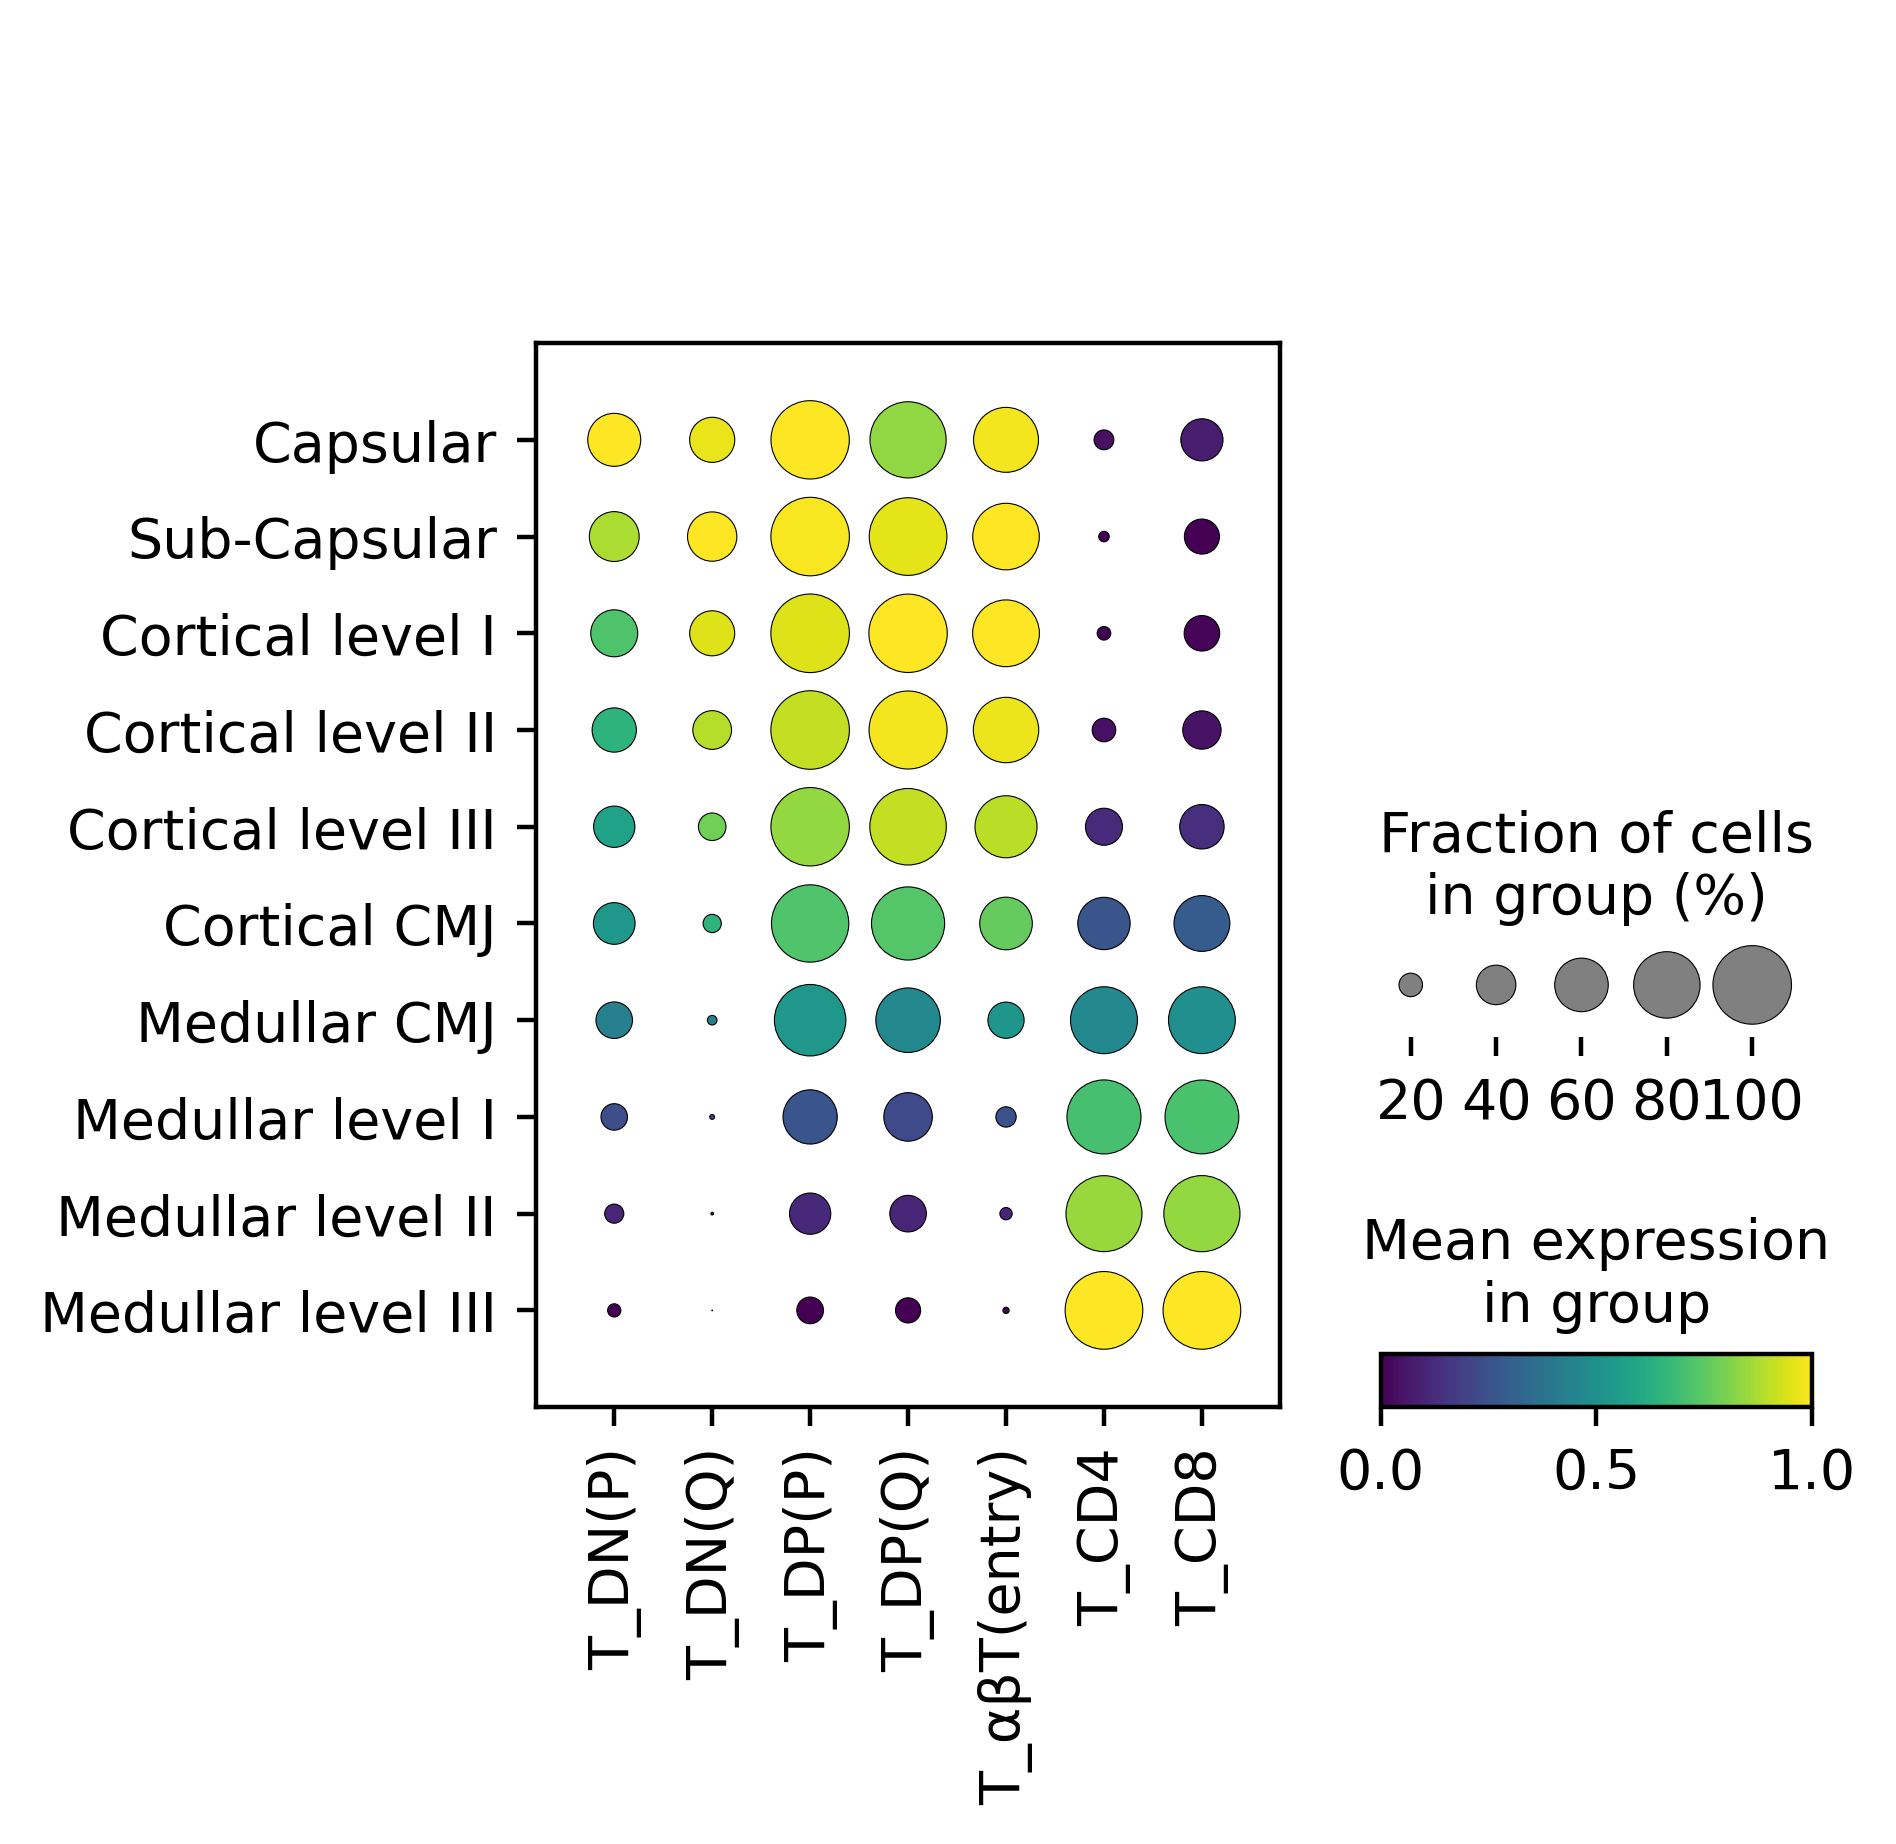

In [9]:
os.chdir('')

cells = ['T_DN(P)', 'T_DN(Q)',
                 'T_DP(P)', 'T_DP(Q)',
                 'T_αβT(entry)', 'T_CD4', 'T_CD8']
cutoff = 2
sc.set_figure_params(figsize=[7,7],fontsize=12,dpi=200)
sc.pl.dotplot(cellab_paed,var_names=cells,
               groupby='manual_bin_cma_v2',cmap='viridis',standard_scale='var',expression_cutoff=cutoff,save='paed_T_cutoff'+str(cutoff)+'.pdf')
              
    

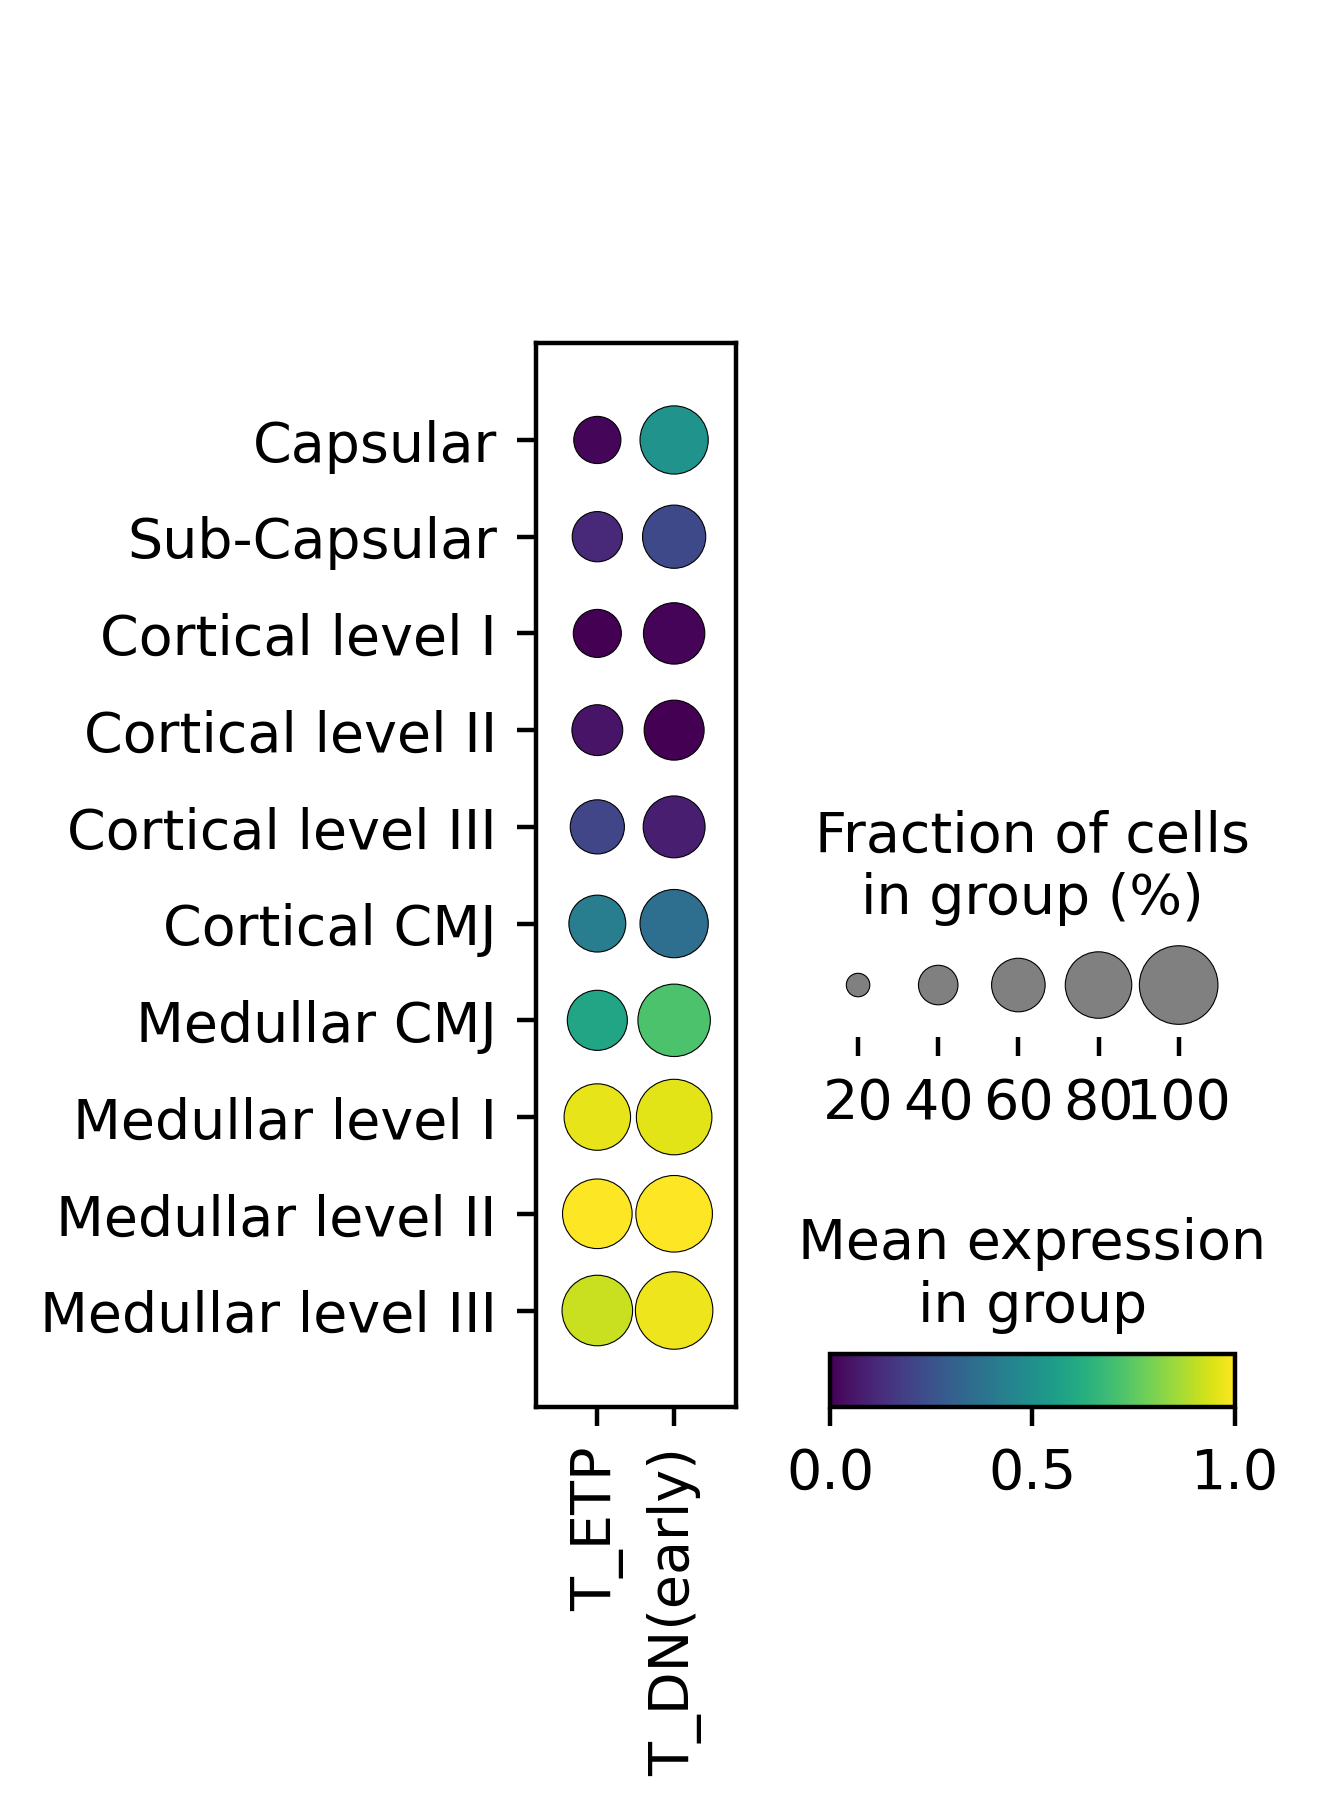

In [10]:
cells = ['T_ETP','T_DN(early)']

cutoff = 0.15
sc.set_figure_params(figsize=[7,7],fontsize=12,dpi=200)
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/new_Figure3/')
sc.pl.dotplot(cellab_paed,var_names=cells,
               groupby='manual_bin_cma_v2',cmap='viridis',standard_scale='var',expression_cutoff=cutoff,save='paed_etp_dn(early)_cutoff'+str(cutoff)+'.pdf')
              
    

# plot other cells for the supp 

In [11]:
sc.set_figure_params(figsize=[5,5],fontsize=10,dpi=100)

dict_anno = {
    'cd8aa': ['T_CD8αα(entry)','T_CD8αα(I)', 'T_CD8αα(II)', ],
    'T_special': [ 'T_γδT','T_cycling', 'T_CD8-Prolif', 'T_CD8_memory','T_NK_dev', 'T_NK', 'T_NK_fetal'],
    'T_DN_DP': ['T_DP(Q)-early','T_DN(Q)-CD99', 'T_DN(Q)-HSPH1', 'T_DP(Q)-CD99', 'T_DP(Q)-HSPH1',  'T_DP(Q)-late_vdj'],
    'T_Treg': ['T_Treg(agonist)', 'T_Treg-diff_1', 'T_Treg-diff_2', 'T_Treg_mature', 'T_Treg_CD8', 'T_Treg_recirc'],
}

del list

['T_CD8αα(entry)', 'T_CD8αα(I)', 'T_CD8αα(II)']
['T_CD8αα(entry)', 'T_CD8αα(I)', 'T_CD8αα(II)']


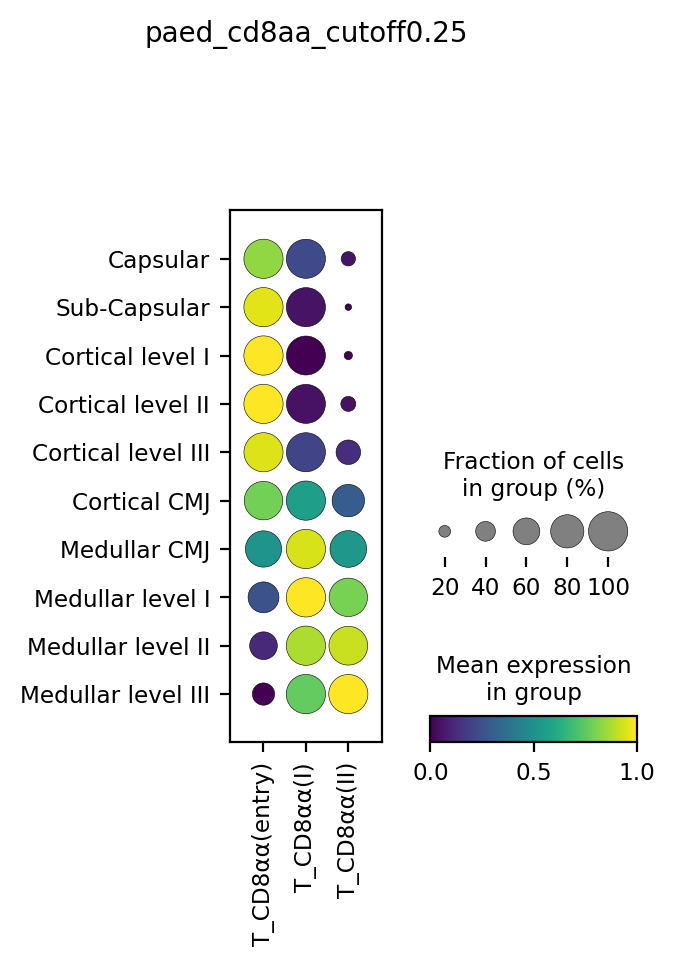

In [14]:
key = list(dict_anno.keys())[0]
selected = dict_anno[key]
print(selected)

selected = [item for item in selected if item in cellab_paed.var_names]
print(selected)
cutoff = 0.25
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/new_Figure3/')
sc.pl.dotplot(cellab_paed,var_names=selected,
               groupby='manual_bin_cma_v2',cmap='viridis',standard_scale='var',expression_cutoff=cutoff,save='paed_'+key+'_cutoff'+str(cutoff)+'.pdf',title='paed_'+key+'_cutoff'+str(cutoff))

['T_γδT', 'T_cycling', 'T_CD8-Prolif', 'T_CD8_memory', 'T_NK_dev', 'T_NK', 'T_NK_fetal']
['T_γδT', 'T_CD8_memory', 'T_NK']


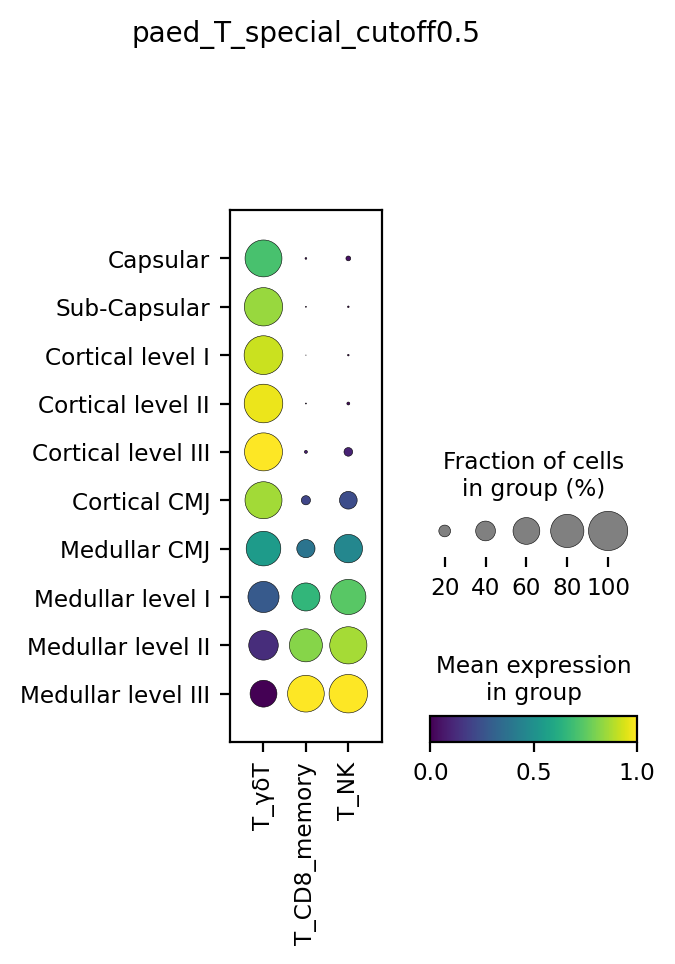

In [16]:
key = list(dict_anno.keys())[1]
selected = dict_anno[key]
print(selected)

selected = [item for item in selected if item in cellab_paed.var_names]
print(selected)
cutoff = 0.5
sc.pl.dotplot(cellab_paed,var_names=selected,
               groupby='manual_bin_cma_v2',cmap='viridis',standard_scale='var',expression_cutoff=cutoff,save='paed_'+key+'_cutoff'+str(cutoff)+'.pdf',title='paed_'+key+'_cutoff'+str(cutoff))

['T_DP(Q)-early', 'T_DN(Q)-CD99', 'T_DN(Q)-HSPH1', 'T_DP(Q)-CD99', 'T_DP(Q)-HSPH1', 'T_DP(Q)-late_vdj']
['T_DP(Q)-early', 'T_DP(Q)-CD99', 'T_DP(Q)-late_vdj']


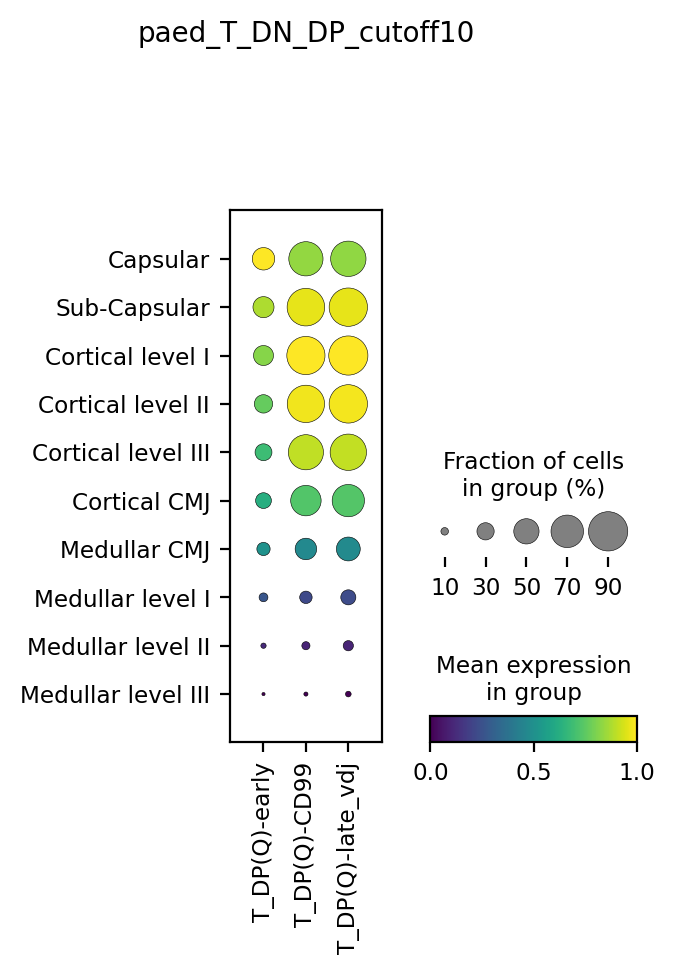

In [17]:
key = list(dict_anno.keys())[2]
selected = dict_anno[key]
print(selected)

selected = [item for item in selected if item in cellab_paed.var_names]
print(selected)
cutoff = 10
sc.pl.dotplot(cellab_paed,var_names=selected,
               groupby='manual_bin_cma_v2',cmap='viridis',standard_scale='var',expression_cutoff=cutoff,save='paed_'+key+'_cutoff'+str(cutoff)+'.pdf',title='paed_'+key+'_cutoff'+str(cutoff))

['T_DP(Q)-early', 'T_DN(Q)-CD99', 'T_DN(Q)-HSPH1', 'T_DP(Q)-CD99', 'T_DP(Q)-HSPH1', 'T_DP(Q)-late_vdj']
['T_DP(Q)-early', 'T_DP(Q)-CD99', 'T_DP(Q)-late_vdj']


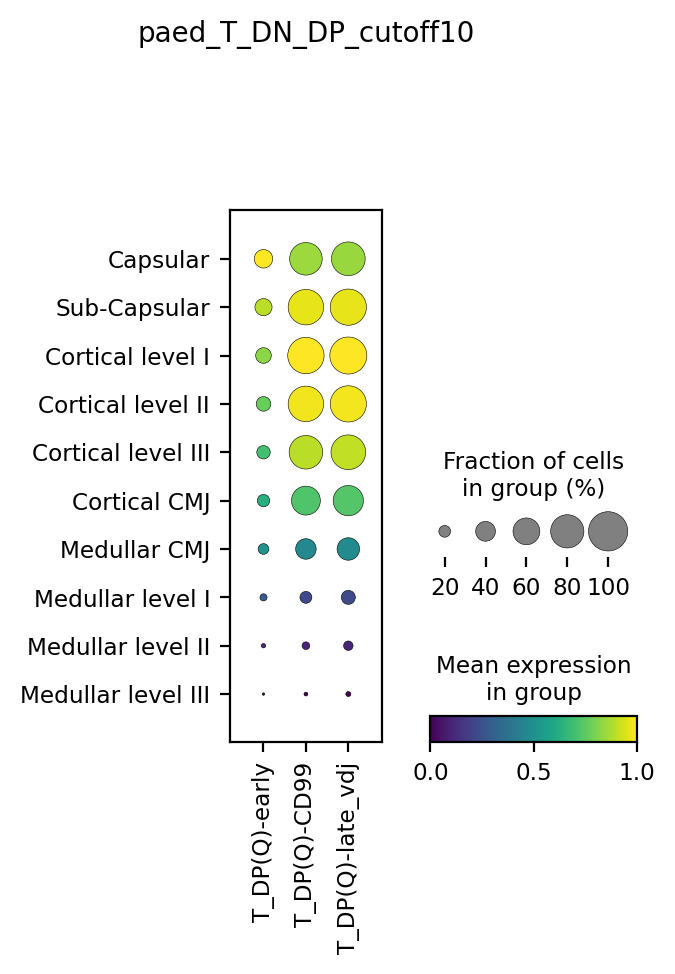

['T_Treg(agonist)', 'T_Treg-diff_1', 'T_Treg-diff_2', 'T_Treg_mature', 'T_Treg_CD8', 'T_Treg_recirc']
['T_Treg(agonist)', 'T_Treg-diff_1', 'T_Treg-diff_2', 'T_Treg_mature', 'T_Treg_CD8', 'T_Treg_recirc']


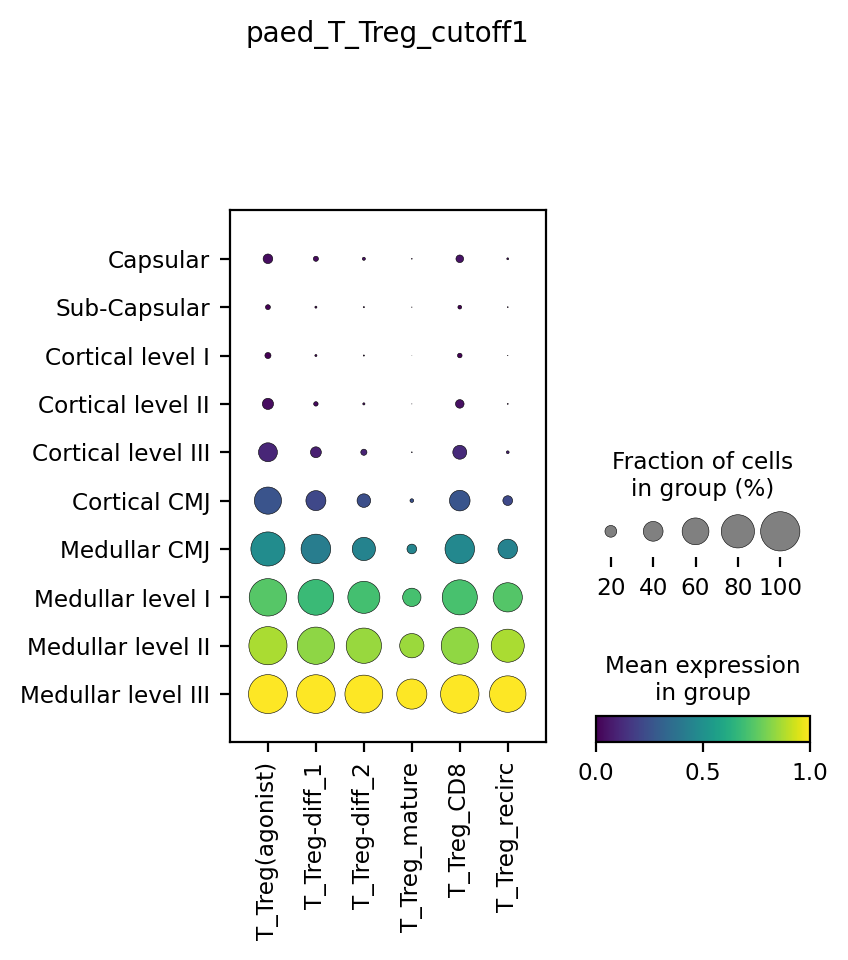

In [19]:
key = list(dict_anno.keys())[3]
selected = dict_anno[key]
print(selected)

selected = [item for item in selected if item in cellab_paed.var_names]
print(selected)
cutoff = 1
sc.pl.dotplot(cellab_paed,var_names=selected,
               groupby='manual_bin_cma_v2',cmap='viridis',standard_scale='var',expression_cutoff=cutoff,save='paed_'+key+'_cutoff'+str(cutoff)+'.pdf',title='paed_'+key+'_cutoff'+str(cutoff))

['T_Treg(agonist)', 'T_Treg-diff_1', 'T_Treg-diff_2', 'T_Treg_mature', 'T_Treg_CD8', 'T_Treg_recirc']
['T_Treg(agonist)', 'T_Treg-diff_1', 'T_Treg-diff_2', 'T_Treg_mature', 'T_Treg_CD8', 'T_Treg_recirc']


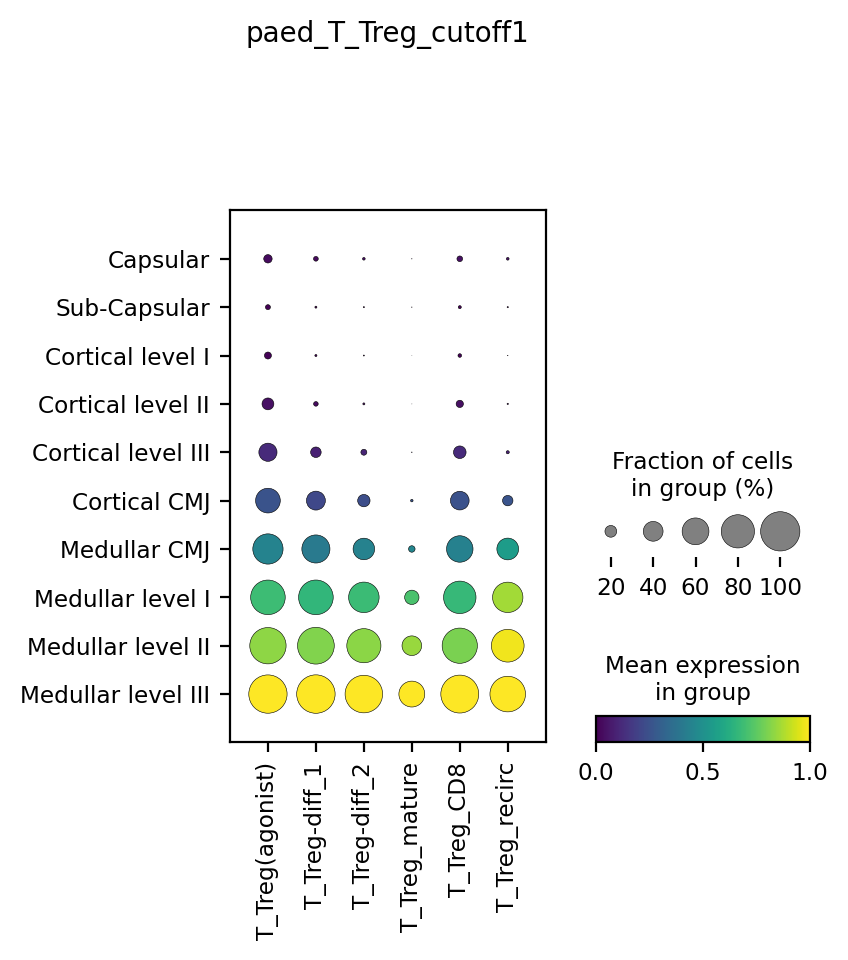

In [37]:
cellab_paed.var_names

Index(['B-memory', 'B-naive', 'B-plasma', 'DC1', 'DC2', 'EC-Art', 'EC-Art-ELN',
       'EC-Cap', 'EC-Lymphatic', 'EC-Ven', 'InterloFb', 'Macrophage-APOC2',
       'Macrophage-SPIC1', 'Monocyte_IL1B', 'Myelocyte', 'Neutrophil',
       'Pericyte', 'Pericyte_CCL19', 'Pericyte_COL1A1', 'PeriloFb', 'SMC',
       'TEC-cilliated', 'TEC-myo', 'TEC-neuro', 'T_CD4', 'T_CD8',
       'T_CD8_memory', 'T_CD8αα(I)', 'T_CD8αα(II)', 'T_CD8αα(entry)',
       'T_DN(P)', 'T_DN(Q)', 'T_DN(early)', 'T_DP(P)', 'T_DP(Q)',
       'T_DP(Q)-CD99', 'T_DP(Q)-early', 'T_DP(Q)-late_vdj', 'T_ETP', 'T_NK',
       'T_Treg(agonist)', 'T_Treg-diff_1', 'T_Treg-diff_2', 'T_Treg_CD8',
       'T_Treg_mature', 'T_Treg_recirc', 'T_innate_type_3', 'T_αβT(entry)',
       'T_γδT', 'aDC1', 'aDC2', 'aDC3', 'cTECI', 'cTECII', 'cTECIII', 'mTECI',
       'mTECI-trans', 'mTECII', 'mTECIII', 'mcTEC', 'medFB-MHCIIh', 'medFb',
       'medFb-RGS5', 'pDC'],
      dtype='object')